Детектор аномалии на принципе многократной прогонки реконструкции входного образца до сходимости латентного вектора.
Критерий аномальности - расстояние от первоначального латентного вектора до сошедшего.

In [1]:
from dataclasses import dataclass
from datetime import datetime

import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np 
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from tqdm.auto import tqdm
from torchfuzzy import FuzzyLayer, DefuzzyLinearLayer, FuzzyBellLayer
import piqa
import sklearn.metrics as metrics
from sklearn.manifold import TSNE
from torchvision.transforms import v2

In [23]:
batch_size = 256
learning_rate = 1e-2
num_epochs = 25
latent_dim = 9
mnist_class_anomaly = 4
kernels = 16

prefix = f"fuzzy_ae"
writer = SummaryWriter(f'runs/mnist/{prefix}_{datetime.now().strftime("%Y%m%d-%H%M%S")}')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

ssim = piqa.SSIM(window_size = 11, n_channels=1, reduction='none').to(device)

## Датасет

1. Исключаем класс аномалии `mnist_class_anomaly` из общей выборк
2. Убираем метки с остальных классов
   

In [24]:
def norm_and_transform(x):
    nimg = x.view(-1, 28, 28)
    nimg = torch.clamp(nimg, 0, 1)
    return nimg

def clamp(x):
    #nimg = 2.0*(x.view(-1, 28, 28) - 0.5)
    nimg = torch.clamp(x, 0, 1)
    return nimg

transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Lambda(norm_and_transform)
])

augmentation = transforms.Compose([
    transforms.RandomRotation(15, fill=0), 
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), fill=0), 
    #transforms.RandomCrop(size=26),
    #transforms.Resize(size=(28, 28)),
    transforms.Lambda(clamp)
])

In [25]:
def get_target_and_mask(target_label):
    t = target_label
    return t 

train_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=True, 
    transform = transform,
    target_transform = transforms.Lambda(lambda x: get_target_and_mask(x))
)

idx = (train_data.targets != mnist_class_anomaly)
train_data.targets = train_data.targets[idx]
train_data.data = train_data.data[idx]
len(train_data)

54158

загружаем тестовую выборку

In [26]:
test_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=False, 
    transform=transform, 
    target_transform = transforms.Lambda(lambda x: get_target_and_mask(x))
)
len(test_data)

10000

Создаем итераторы датасетов

In [27]:

train_loader = torch.utils.data.DataLoader(
    train_data, 
    batch_size=batch_size, 
    shuffle=True,
    
)
test_loader = torch.utils.data.DataLoader(
    test_data, 
    batch_size=batch_size, 
    shuffle=False,
)

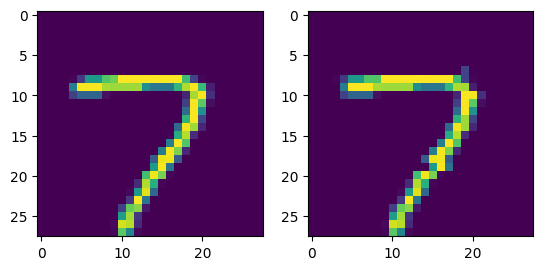

In [28]:
for data,_ in iter(train_loader):
    R, C = 1, 2
    plt.subplot(R, C, 1)
    plt.imshow(data[0].squeeze())
    plt.subplot(R, C, 2)
    plt.imshow(augmentation(data)[0].squeeze())
    
    
    break

## Модель

In [29]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.SiLU()]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class Encoder(nn.Module):
    """
    Компонент энкодера для VAE
    
    Args:
        latent_dim (int): Размер латентного вектора.
    """
    
    def __init__(self, latent_dim, kernels):
        super(Encoder, self).__init__()
        
        self.kernels = kernels
        self.latent_dim = latent_dim
        self.conv1 = conv_block(1, 2*kernels)
        self.conv2 = conv_block(2*kernels, 4*kernels, pool=True)
        self.res1 = nn.Sequential(conv_block(4*kernels, 4*kernels), conv_block(4*kernels, 4*kernels))
        
        self.conv3 = conv_block(4*kernels, 8*kernels, pool=True)
        self.conv4 = conv_block(8*kernels, 16*kernels, pool=True)
        self.res2 = nn.Sequential(conv_block(16*kernels, 16*kernels), conv_block(16*kernels, 16*kernels))

        #self.after_sum = nn.SiLU()
        #self.softplus = nn.Softplus()
        self.latent = nn.Sequential(
            nn.Flatten(2),
            #nn.Conv2d(16*kernels, latent_dim, 3),
            #nn.BatchNorm2d(latent_dim, track_running_stats=True),
            #nn.Sigmoid(),
            #nn.Flatten(),
            #nn.Linear(16*kernels*9, latent_dim), # mean + variance.
        )
        self.fuzzy = FuzzyLayer.from_dimensions(9, self.latent_dim)

         
    def forward(self, x):
        """
        Выход энкодера для чистого VAE.
        
        Args:
            x (torch.Tensor): Входной вектор.
            eps (float): Небольшая поправка к скейлу для лучшей сходимости и устойчивости.
        
        Returns:
            mu, logvar, z, dist
        """

        out = self.conv1(x)
        out = self.conv2(out)
        out = self.res1(out) + out

        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out

        out = self.latent(out)
        out = out.reshape(-1, 9)
        out = self.fuzzy(out)
        out = out.reshape(-1, 16*self.kernels, self.latent_dim)
        out = out.sum(1)
        return out

inp = torch.rand(10, 1, 28, 28)
m = Encoder(latent_dim, 2)
mu = m.forward(inp)
mu.shape

torch.Size([10, 3])

In [30]:
class Decoder(nn.Module):
    """
    Компонент декодера для VAE
    
    Args:
        latent_dim (int): Размер латентного вектора.
    """
    
    def __init__(self, latent_dim, kernels):
        super(Decoder, self).__init__()

        self.input = nn.Sequential(
            nn.Unflatten(1, (latent_dim, 1, 1)),
            nn.BatchNorm2d(latent_dim, track_running_stats=True),
            nn.SiLU(),
        )

        self.block_1 = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 16*kernels, 4),
            nn.BatchNorm2d(16*kernels, track_running_stats=True),
            nn.SiLU(), 
            nn.ConvTranspose2d(16*kernels, 16*kernels, 4),
            nn.BatchNorm2d(16*kernels, track_running_stats=True),
            nn.SiLU(), 
        )

        self.block_2 = nn.Sequential(
            nn.ConvTranspose2d(16*kernels, 8*kernels, 4),
            nn.BatchNorm2d(8*kernels, track_running_stats=True),
            nn.SiLU(), 
            nn.ConvTranspose2d(8*kernels, 8*kernels, 4),
            nn.BatchNorm2d(8*kernels, track_running_stats=True),
            nn.SiLU(), 
        )

        self.block_3 = nn.Sequential(
            nn.ConvTranspose2d(8*kernels, 4*kernels, 4),
            nn.BatchNorm2d(4*kernels, track_running_stats=True),
            nn.SiLU(), 
            nn.ConvTranspose2d(4*kernels, 4*kernels, 4),
            nn.BatchNorm2d(4*kernels, track_running_stats=True),
            nn.SiLU(), 
        )

        self.block_4 = nn.Sequential(
            nn.ConvTranspose2d(4*kernels, 2*kernels, 4),
            nn.BatchNorm2d(2*kernels, track_running_stats=True),
            nn.SiLU(), 
            nn.ConvTranspose2d(2*kernels, 2*kernels, 4),
            nn.BatchNorm2d(2*kernels, track_running_stats=True),
            nn.SiLU(), 
        )

        self.block_5 = nn.Sequential(
            nn.ConvTranspose2d(2*kernels, kernels, 2),
            nn.BatchNorm2d(kernels, track_running_stats=True),
            nn.SiLU(), 
            nn.ConvTranspose2d(kernels, kernels, 2),
            nn.BatchNorm2d(kernels, track_running_stats=True),
            nn.SiLU(), 
        )

        self.output = nn.Sequential(
            nn.ConvTranspose2d(kernels, 1, 2),
            nn.Sigmoid() 
        )
        self.upscale_1 = nn.Sequential(nn.ConvTranspose2d(latent_dim, 16*kernels, kernel_size=7))
        self.upscale_2 = nn.Sequential(nn.ConvTranspose2d(16*kernels, 8*kernels, kernel_size=7))
        self.upscale_3 = nn.Sequential(nn.ConvTranspose2d( 8*kernels, 4*kernels, kernel_size=7))
        self.upscale_4 = nn.Sequential(nn.ConvTranspose2d( 4*kernels, 2*kernels, kernel_size=7))
        self.upscale_5 = nn.Sequential(nn.ConvTranspose2d( 2*kernels, kernels,   kernel_size=3))
        self.after_sum = nn.SiLU()
         
    def forward(self, z):
        """
        Декодирует латентный вектор в исходное представление
        
        Args:
            z (torch.Tensor): Латентный вектор.
        
        Returns:
            x
        """
        
        mapx = self.input(z)

        x = self.decode_from_mp(mapx)
        return x
    
    def decode_from_mp(self, x):
        res = self.upscale_1(x)
        #print(res.shape)
        x = self.block_1(x)
        #print(x.shape)
        x = self.after_sum(x+res)

        res = self.upscale_2(x)
        #print(res.shape)
        x = self.block_2(x)
        #print(x.shape)
        x = self.after_sum(x+res)

        res = self.upscale_3(x)
        x = self.block_3(x)
        x = self.after_sum(x+res)

        res = self.upscale_4(x)
        x = self.block_4(x)
        x = self.after_sum(x+res)

        res = self.upscale_5(x)
        x = self.block_5(x)
        x = self.after_sum(x+res)
        
        return self.output(x)
    
inp = torch.rand(10, latent_dim)
m = Decoder(latent_dim, 2)
mu = m.forward(inp)
mu.shape

torch.Size([10, 1, 28, 28])

In [31]:
class VAE(nn.Module):
    """
    Args:
        latent_dim (int): Размер латентного вектора.
    """
    def __init__(self, latent_dim, kernels):
        super(VAE, self).__init__()

        self.encoder = Encoder(latent_dim, kernels)        
        self.decoder = Decoder(latent_dim, kernels)
        #self.resd = Decoder(latent_dim, fuzzy_rules_count)
        

    def forward(self, x):
        """
        
        """
        mu = self.encoder(x)
        x_recon = self.decoder(mu)
        
        return mu, x_recon
    
    def half_pass(self, x):
        """
        
        """
        mu = self.encoder(x)
        return mu
    
    def decoder_pass(self, x):
        r = self.decoder(x)
        return r

## Обучение

In [32]:
model = VAE(latent_dim=latent_dim, kernels=kernels).to(device)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of parameters: {num_params:,}')

model

Number of parameters: 5,893,561


VAE(
  (encoder): Encoder(
    (conv1): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU()
    )
    (conv2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (res1): Sequential(
      (0): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU()
      )
      (1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2):

In [33]:
#optimizer = torch.optim.Adam(list(model.encoder.parameters()) + list(model.decoder.parameters()), lr=learning_rate)
#optimizer_d = torch.optim.Adam(model.delta_decoder.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, learning_rate, epochs=num_epochs, steps_per_epoch=len(train_loader))

In [34]:
def tarctanh(x):
    return 0.5 * torch.log((1+x)/(1-x))

def log_norm_const(x, eps = 1e-6):
    # numerically stable computation
    x = torch.clamp(x, eps, 1 - eps)
    x = torch.where((x < 0.49) | (x > 0.51), x, 0.49 *
            torch.ones_like(x))
    return torch.log((2 * tarctanh(1 - 2 * x)) /
                    (1 - 2 * x) + eps)

def xent_continuous_ber(recon_x, x, pixelwise=False):
    ''' p(x_i|z_i) a continuous bernoulli '''
    eps = 1e-6
    if pixelwise:
        return (x * torch.log(recon_x + eps) +
                        (1 - x) * torch.log(1 - recon_x + eps) +
                        log_norm_const(recon_x, eps))
    else:
        return torch.mean(torch.sum(x * torch.log(recon_x + eps) +
                        (1 - x) * torch.log(1 - recon_x + eps) +
                        log_norm_const(recon_x, eps), dim=(1, )), dim=(1, 2))
    

a = -torch.ones(3, 1, 28, 28)
b = -torch.ones(3, 1, 28, 28)

xent_continuous_ber((a + 1)/2, (b + 1)/2)

tensor([2.6248, 2.6248, 2.6248])

In [35]:
def compute_vae_loss(x, recon_x):
    
    loss_recon = (x - recon_x).square().sum(-1).sum(-1).mean()
    #loss_recon = -xent_continuous_ber(recon_x, x)
    #loss_recon = loss_recon.mean()
    #loss_recon = (1 - ssim(recon_x.clamp(0, 1), x))
    #loss_recon = loss_recon.mean()
    
    #raw_loss_recon = (1 - diff).square() #F.binary_cross_entropy((recon_x+1)/2, (x + 1)/2, reduction='none').sum(-1).mean()#
    #loss_recon = raw_loss_recon.mean()
    
    return loss_recon #(x-recon_x).square().sum(-1).sum(-1).mean()
    

In [36]:
eigens = model.encoder.fuzzy.get_transformation_matrix_eigenvals().real


In [37]:
def compute_fshape_loss(fuzzy_layer):
    
    eigens = fuzzy_layer.get_transformation_matrix_eigenvals().real
    fz_volume = (0.1 - eigens).square()
    fz_volume = fz_volume.mean()
    
    #fz_scales = (1 - eigens).square().mean()

    return fz_volume
compute_fshape_loss(model.encoder.fuzzy)
    

tensor(0.8100, device='cuda:0', grad_fn=<MeanBackward0>)

In [38]:
def keep_eigenvals_positive_loss(layer, eps = 1e-15):
    ev = layer.get_transformation_matrix_eigenvals().real.min()
    ev = torch.clamp(ev, max=eps)
    return -ev
keep_eigenvals_positive_loss(model.encoder.fuzzy)

tensor(-1.0000e-15, device='cuda:0', grad_fn=<NegBackward0>)

In [39]:
def get_arate(inp):
    _, x_recon = model.forward(inp)
    
    # prev_mu = mu
    # sum = torch.zeros_like(mu)
    
    # for i in range(20):
    #     recon_x = model.decoder_pass(mu)
    #     mu, _, _ = model.half_pass(recon_x)
    #     sum += (mu - prev_mu).abs()
    #     prev_mu = mu
    # +
    return (1 - ssim(x_recon.clamp(0, 1), inp)).cpu().numpy()#xent_continuous_ber((x_recon + 1)/2, (inp + 1)/2).cpu().numpy()# #ssim((inp + 1)/2, (recon_x+1)/2).cpu().numpy() #fz.sum(-1).cpu().numpy()#

In [40]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    
def train(model, dataloader, optimizer, sched, prev_updates, epoch, writer=None):
    model.train()  
    
    for batch_idx, (data, _) in enumerate(tqdm(dataloader, disable=True)):
        n_upd = prev_updates + batch_idx
        
        data = data.to(device)
        adata = augmentation(data)
        
        optimizer.zero_grad()  
        z = model.half_pass(adata)  
        x_reconstruct = model.decoder_pass(z)
        
        loss_reconstruct = compute_vae_loss(data, x_reconstruct)
        
        ev_loss = keep_eigenvals_positive_loss(model.encoder.fuzzy)
        if ev_loss.item() > 0:
            ev_loss.backward(retain_graph=True)
        
        loss_reconstruct.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.12)
        optimizer.step()  
        
        if sched is not None:
            sched.step()
        
        
    if writer is not None:
        writer.add_scalar('FuzzyVAE/LR', get_lr(optimizer), global_step=epoch)
        
    return prev_updates + len(dataloader)

In [47]:
fixed_random_z = torch.randn(16, latent_dim).to(device)

def test(model, dataloader, cur_step, epoch, writer=None):
    model.eval() 
    test_recon_loss = 0
    test_fzvol_loss = 0
    
    lab_true = []
    lab_pred = []

    with torch.no_grad():
        for data, lab in tqdm(test_loader, desc='Test MNIST', disable=True):
            data = data.view((-1,1,28,28)).to(device)
            rates = get_arate(data)
            
            for f, l in  zip(rates, lab):
                lab_pred.append(f)        
                if l == mnist_class_anomaly:
                    lab_true.append(1)
                else:
                    lab_true.append(0)
                        
    fpr, tpr, _ = metrics.roc_curve(lab_true, lab_pred)
    roc_auc = metrics.auc(fpr, tpr)
    
    embedings = []
    labels_expected = []
    centroids = model.encoder.fuzzy.get_centroids().detach().cpu().numpy()
    #centroids_resd = model.resd.fuzzy[1].get_centroids().detach().cpu().numpy()
    
    with torch.no_grad():
        for data, target in tqdm(dataloader, desc='Testing', disable=True):
            data = data.to(device)
            z = model.half_pass(data)  
            x_reconstruct= model.decoder_pass(z)
            
            embedings.append(z.cpu().numpy())
            labels_expected.append(target.cpu().numpy())

            loss_recon = compute_vae_loss(data, x_reconstruct)
            fz_volume = compute_fshape_loss(model.encoder.fuzzy)
            
            test_recon_loss += loss_recon.item()
            test_fzvol_loss += fz_volume.item()
            

    embedings = np.concatenate(embedings, axis=0)
    labels_expected = np.concatenate(labels_expected, axis=0)

    if epoch % 5 == 1:
        plt.figure(figsize=(18, 6))

        R, C = 1, 3

        plt.subplot(R, C, 1)
        plt.title("MNIST XY")
        plt.scatter(embedings[:, 0],      embedings[:,  1], c=labels_expected, cmap='tab10', s=2)
        plt.scatter(centroids[:, 0],      centroids[:, 1], marker='1', c='black', s= 50)
        #plt.scatter(centroids_resd[:, 0],      centroids_resd[:, 1], marker='2', c='red', s= 20)
        
        # plt.xlim((-1, 1))
        # plt.ylim((-1, 1))

        plt.subplot(R, C, 2)
        plt.title("MNIST XZ")
        plt.scatter(embedings[:, 0],      embedings[:,  2], c=labels_expected, cmap='tab10', s=2)
        plt.scatter(centroids[:, 0],      centroids[:, 2], marker='1', c='black', s= 50)
        #plt.scatter(centroids_resd[:, 0], centroids_resd[:, 2], marker='2', c='red', s= 20)
        
        # plt.xlim((-1, 1))
        # plt.ylim((-1, 1))

        plt.show()
    
    test_recon_loss /= len(dataloader)
    test_fzvol_loss /= len(dataloader)
    print(f'[{cur_step}] Reconstruction loss: {test_recon_loss:.4f}, AUC {roc_auc:.4f} FZ {test_fzvol_loss:.4f}')
    
    if writer is not None:
        writer.add_scalar('FuzzyVAE/AUC', roc_auc, global_step=cur_step)
        writer.add_scalar('FuzzyVAE/Reconstruction', test_recon_loss, global_step=cur_step)
        writer.add_scalar('FuzzyVAE/Fuzzy/Vol', test_fzvol_loss, global_step=cur_step)
        samples = model.decoder_pass(fixed_random_z)
        writer.add_images('FuzzyVAE/Samples', samples.view(-1, 1, 28, 28), global_step=cur_step)

In [48]:
prev_updates = 0

[212] Reconstruction loss: 32.5652, AUC 0.7287 FZ 0.7972


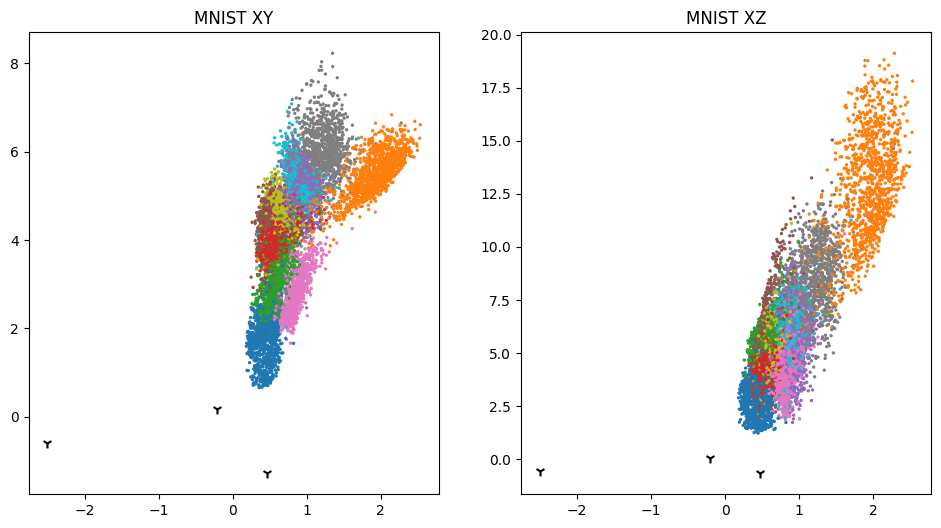

[424] Reconstruction loss: 32.4245, AUC 0.8015 FZ 0.7981
[636] Reconstruction loss: 29.4346, AUC 0.7372 FZ 0.7987
[848] Reconstruction loss: 30.5334, AUC 0.7565 FZ 0.7992
[1060] Reconstruction loss: 30.8607, AUC 0.7054 FZ 0.8001
[1272] Reconstruction loss: 31.8824, AUC 0.6927 FZ 0.8044


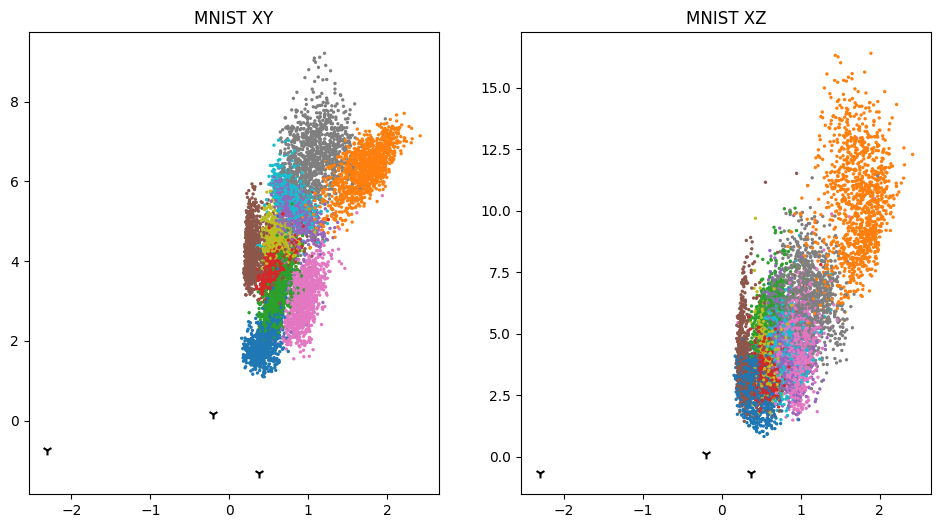

[1484] Reconstruction loss: 31.0105, AUC 0.7263 FZ 0.8092
[1696] Reconstruction loss: 28.7518, AUC 0.7241 FZ 0.8158
[1908] Reconstruction loss: 29.6492, AUC 0.7743 FZ 0.8275
[2120] Reconstruction loss: 26.9961, AUC 0.7961 FZ 0.8371
[2332] Reconstruction loss: 27.9273, AUC 0.7961 FZ 0.8503


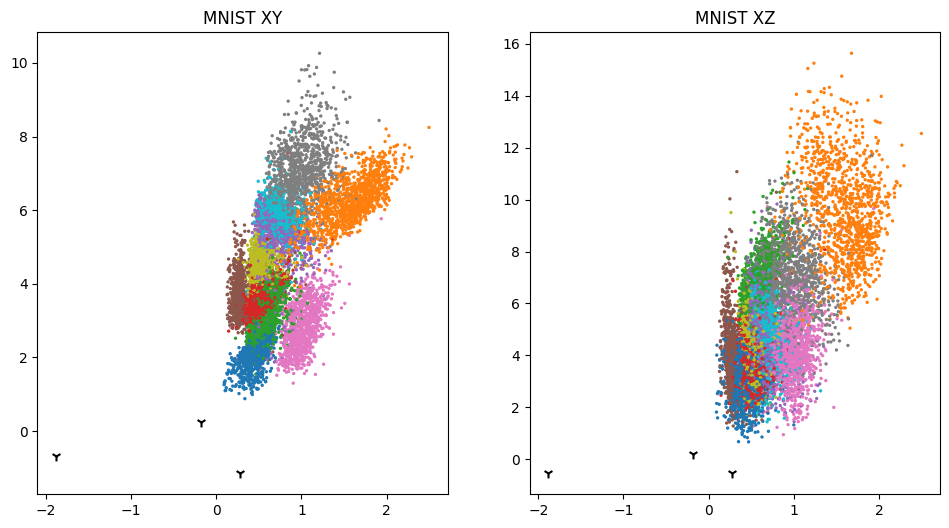

[2544] Reconstruction loss: 29.5653, AUC 0.8082 FZ 0.8674
[2756] Reconstruction loss: 28.9438, AUC 0.8205 FZ 0.8805
[2968] Reconstruction loss: 27.7990, AUC 0.7690 FZ 0.9027
[3180] Reconstruction loss: 29.8596, AUC 0.7895 FZ 0.9186
[3392] Reconstruction loss: 30.2167, AUC 0.7856 FZ 0.9477


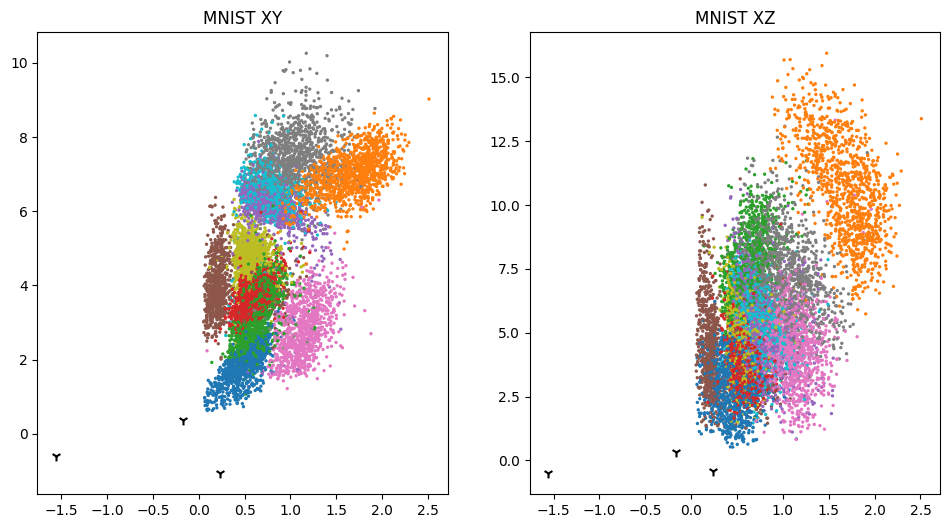

[3604] Reconstruction loss: 25.3713, AUC 0.7991 FZ 0.9644
[3816] Reconstruction loss: 25.3556, AUC 0.8261 FZ 0.9921
[4028] Reconstruction loss: 30.8005, AUC 0.7750 FZ 1.0219
[4240] Reconstruction loss: 25.6412, AUC 0.7839 FZ 1.0420
[4452] Reconstruction loss: 25.9833, AUC 0.8236 FZ 1.0666


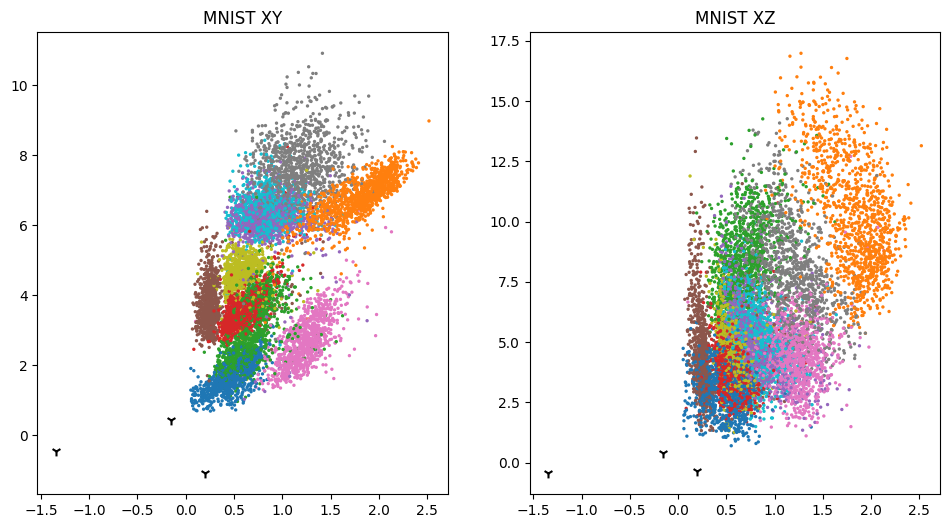

[4664] Reconstruction loss: 27.4155, AUC 0.7914 FZ 1.0868
[4876] Reconstruction loss: 24.6314, AUC 0.7777 FZ 1.1104
[5088] Reconstruction loss: 24.6233, AUC 0.8174 FZ 1.1396
[5300] Reconstruction loss: 27.0097, AUC 0.8193 FZ 1.1616
[5512] Reconstruction loss: 27.0585, AUC 0.8142 FZ 1.1851


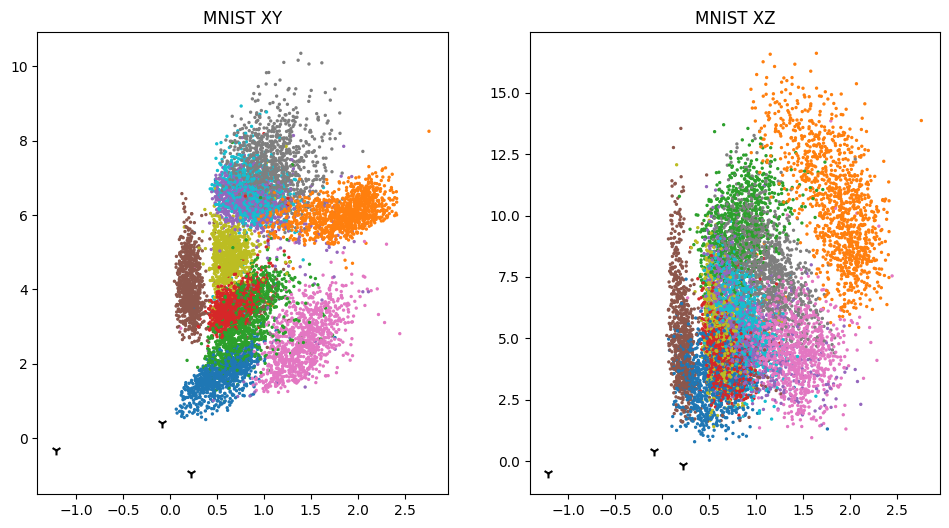

[5724] Reconstruction loss: 25.9172, AUC 0.7766 FZ 1.2108
[5936] Reconstruction loss: 25.0226, AUC 0.8189 FZ 1.2220
[6148] Reconstruction loss: 26.8174, AUC 0.8065 FZ 1.2478
[6360] Reconstruction loss: 26.8402, AUC 0.8493 FZ 1.2845
[6572] Reconstruction loss: 25.7538, AUC 0.7858 FZ 1.2982


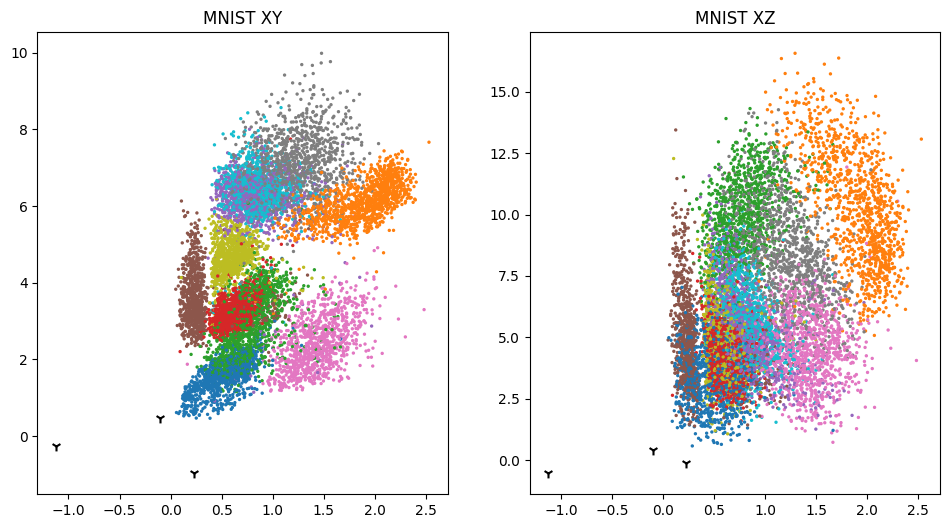

[6784] Reconstruction loss: 25.0148, AUC 0.7764 FZ 1.3239
[6996] Reconstruction loss: 24.7923, AUC 0.8187 FZ 1.3378
[7208] Reconstruction loss: 26.6898, AUC 0.7732 FZ 1.3495
[7420] Reconstruction loss: 26.3536, AUC 0.7573 FZ 1.3699
[7632] Reconstruction loss: 26.6775, AUC 0.8120 FZ 1.3838


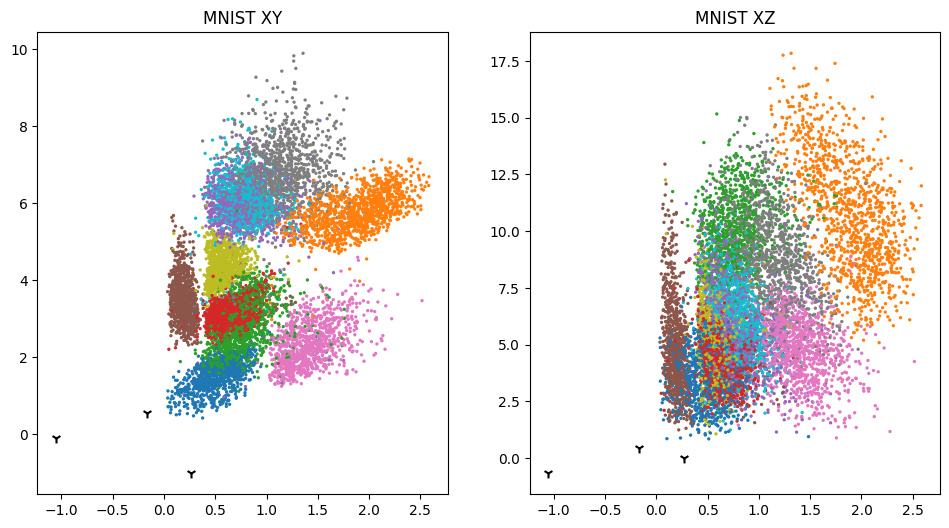

[7844] Reconstruction loss: 25.2737, AUC 0.8059 FZ 1.4066
[8056] Reconstruction loss: 26.2736, AUC 0.7756 FZ 1.4333
[8268] Reconstruction loss: 25.7220, AUC 0.7622 FZ 1.4540
[8480] Reconstruction loss: 26.7039, AUC 0.8278 FZ 1.4790
[8692] Reconstruction loss: 26.1235, AUC 0.7584 FZ 1.4985


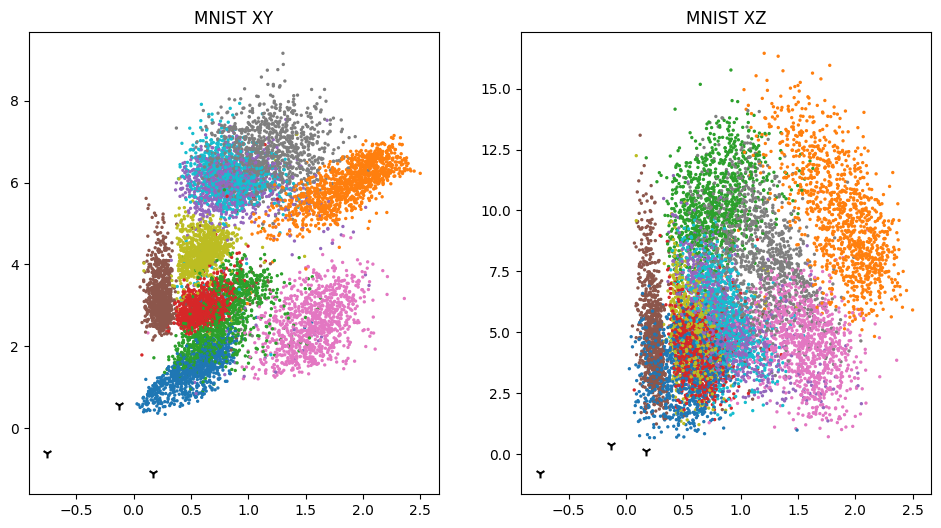

[8904] Reconstruction loss: 24.7687, AUC 0.8042 FZ 1.5052
[9116] Reconstruction loss: 29.6225, AUC 0.7648 FZ 1.5270
[9328] Reconstruction loss: 23.8398, AUC 0.7846 FZ 1.5301
[9540] Reconstruction loss: 26.5476, AUC 0.7557 FZ 1.5598
[9752] Reconstruction loss: 27.0098, AUC 0.8433 FZ 1.5885


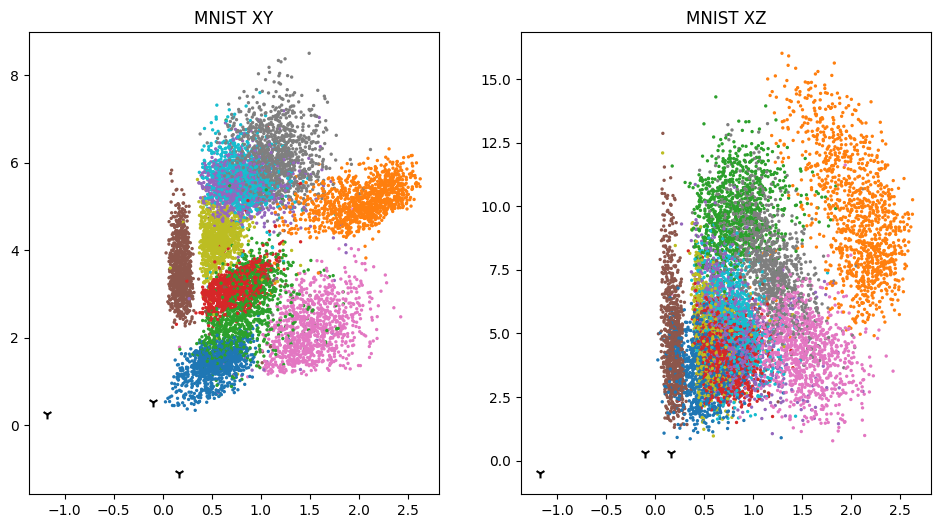

[9964] Reconstruction loss: 25.4923, AUC 0.7799 FZ 1.6103
[10176] Reconstruction loss: 23.8455, AUC 0.7995 FZ 1.6150
[10388] Reconstruction loss: 25.0024, AUC 0.7799 FZ 1.6352
[10600] Reconstruction loss: 29.9221, AUC 0.7195 FZ 1.6399
[10812] Reconstruction loss: 26.2291, AUC 0.7629 FZ 1.6736


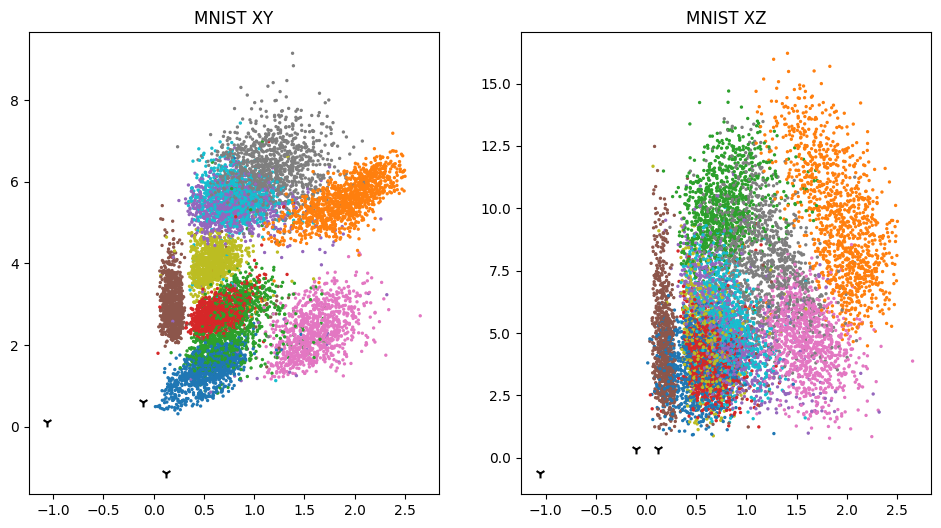

[11024] Reconstruction loss: 24.5059, AUC 0.8155 FZ 1.6779
[11236] Reconstruction loss: 25.0085, AUC 0.8342 FZ 1.6966
[11448] Reconstruction loss: 24.6724, AUC 0.8079 FZ 1.7109
[11660] Reconstruction loss: 23.2261, AUC 0.7891 FZ 1.7266
[11872] Reconstruction loss: 25.0085, AUC 0.7974 FZ 1.7443


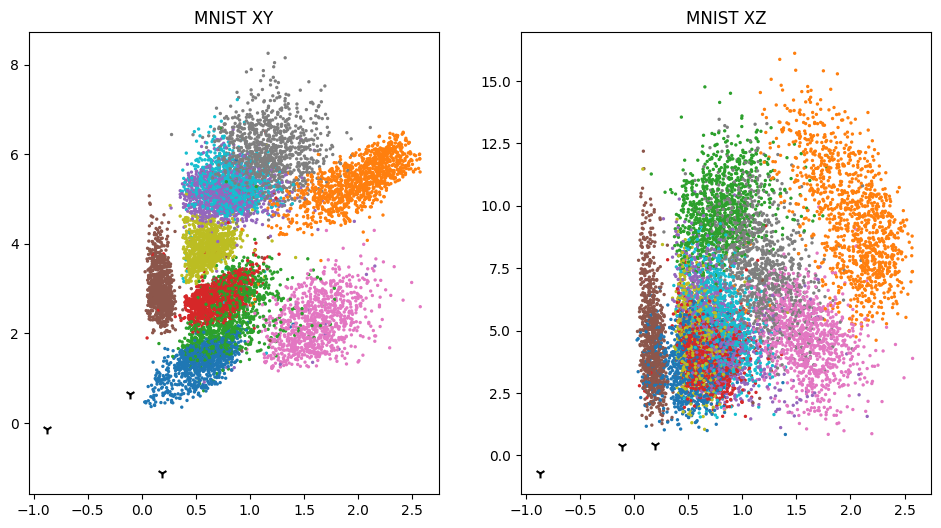

[12084] Reconstruction loss: 27.0393, AUC 0.8442 FZ 1.7482
[12296] Reconstruction loss: 23.7056, AUC 0.8102 FZ 1.7675
[12508] Reconstruction loss: 27.5692, AUC 0.7633 FZ 1.7667
[12720] Reconstruction loss: 22.7190, AUC 0.8177 FZ 1.7712
[12932] Reconstruction loss: 26.0275, AUC 0.8391 FZ 1.7905


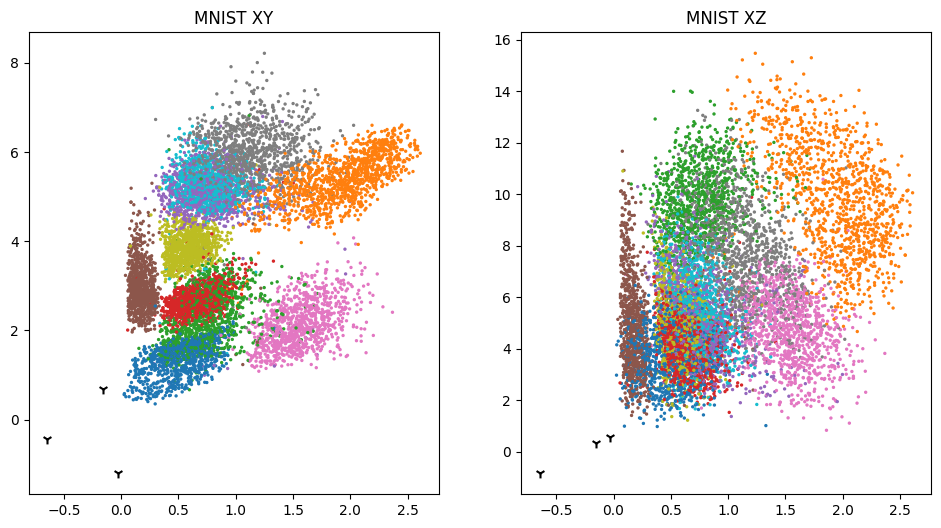

[13144] Reconstruction loss: 24.4586, AUC 0.8044 FZ 1.8042
[13356] Reconstruction loss: 25.9730, AUC 0.7764 FZ 1.8089
[13568] Reconstruction loss: 25.2501, AUC 0.7969 FZ 1.8251
[13780] Reconstruction loss: 29.5126, AUC 0.7064 FZ 1.8317
[13992] Reconstruction loss: 22.9193, AUC 0.8139 FZ 1.8413


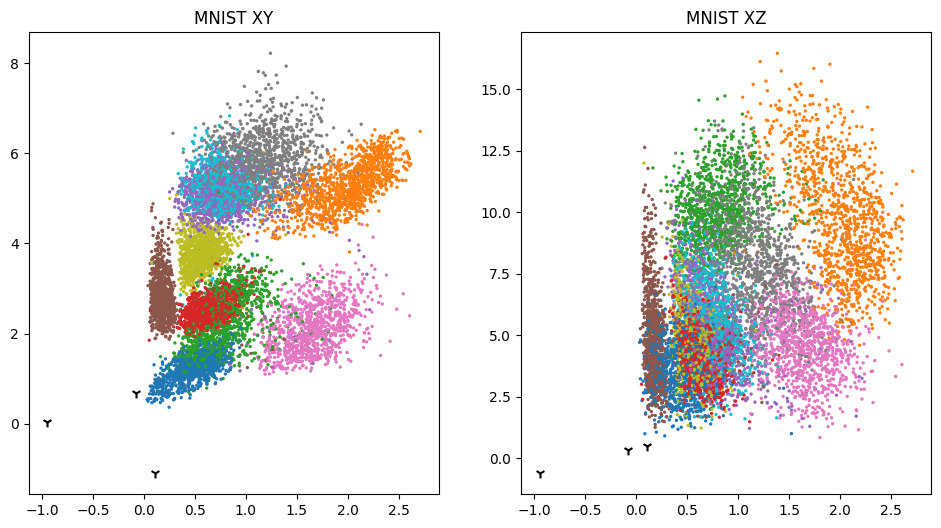

[14204] Reconstruction loss: 22.8377, AUC 0.8062 FZ 1.8593
[14416] Reconstruction loss: 25.5745, AUC 0.7722 FZ 1.8707
[14628] Reconstruction loss: 23.2452, AUC 0.7931 FZ 1.8725
[14840] Reconstruction loss: 23.1733, AUC 0.8079 FZ 1.8934
[15052] Reconstruction loss: 30.5772, AUC 0.7733 FZ 1.9074


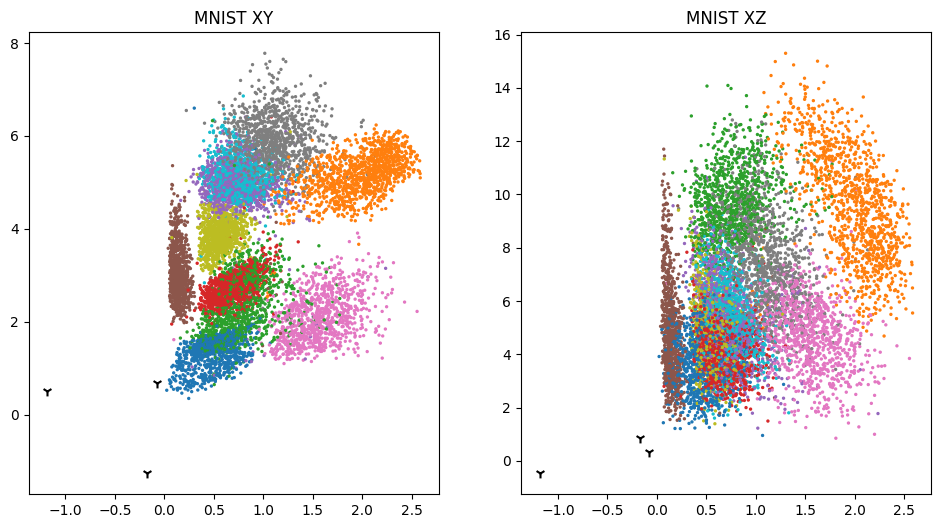

[15264] Reconstruction loss: 25.5296, AUC 0.8049 FZ 1.9138
[15476] Reconstruction loss: 23.9359, AUC 0.7880 FZ 1.9205
[15688] Reconstruction loss: 22.7389, AUC 0.8059 FZ 1.9244
[15900] Reconstruction loss: 23.2346, AUC 0.8022 FZ 1.9417
[16112] Reconstruction loss: 22.0396, AUC 0.8061 FZ 1.9449


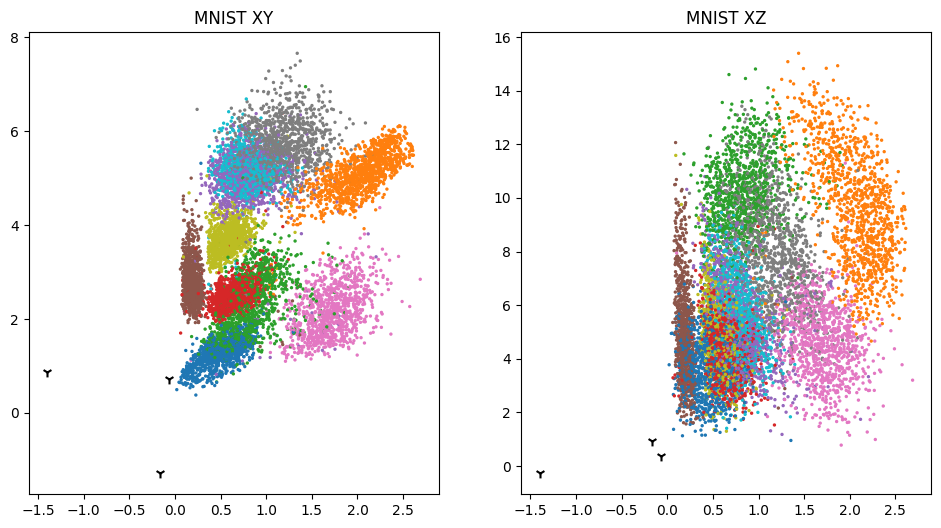

[16324] Reconstruction loss: 22.3500, AUC 0.8132 FZ 1.9570
[16536] Reconstruction loss: 22.7548, AUC 0.8074 FZ 1.9598
[16748] Reconstruction loss: 22.2958, AUC 0.8147 FZ 1.9662
[16960] Reconstruction loss: 21.8879, AUC 0.8190 FZ 1.9709
[17172] Reconstruction loss: 22.5167, AUC 0.8288 FZ 1.9775


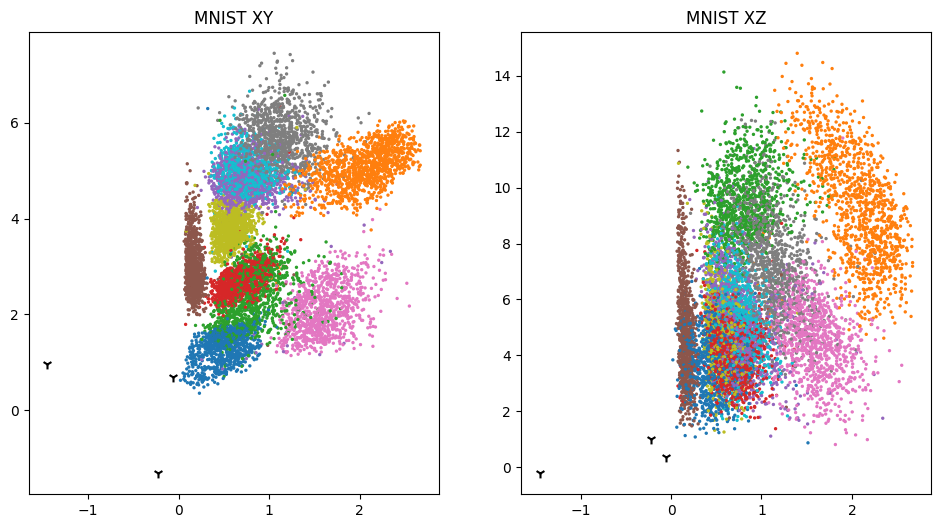

[17384] Reconstruction loss: 24.7412, AUC 0.8107 FZ 1.9854
[17596] Reconstruction loss: 22.3567, AUC 0.8116 FZ 1.9845


KeyboardInterrupt: 

In [49]:
for epoch in range(num_epochs):
    prev_updates = train(model, train_loader, optimizer, sched, prev_updates, epoch, writer=writer)
    test(model, test_loader, prev_updates, epoch, writer=writer)
    #scheduler.step()
    


In [51]:
keep_eigenvals_positive_loss(model.encoder.fuzzy)

tensor(-1.0000e-15, device='cuda:0', grad_fn=<NegBackward0>)

## Визуализируем результаты

  0%|          | 0/212 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

<BarContainer object of 3 artists>

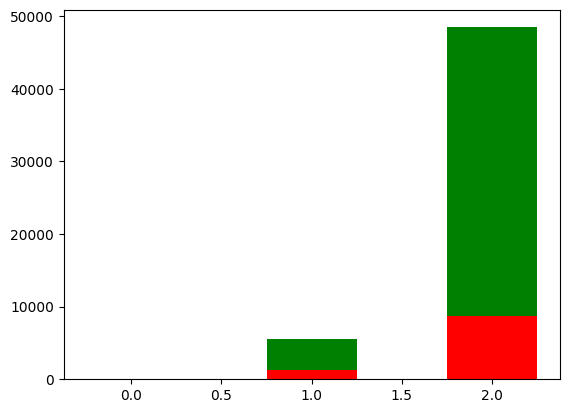

In [53]:

def get_activation_stats(model, dataloader):
    rulestat = {}
    with torch.no_grad():
        for _, (data, _) in enumerate(tqdm(dataloader)):
            data = data.to(device)
            fz, _ = model.forward(data)
            act_fz = fz.max(-1).indices.cpu().numpy()
            for ind in act_fz:
                rulestat[ind] = rulestat.get(ind, 0) + 1
    return rulestat

train_stat = get_activation_stats(model, train_loader)
test_stat = get_activation_stats(model, test_loader)

plt.bar(list(train_stat.keys()), train_stat.values(), 0.5, color='g')
plt.bar(list(test_stat.keys()), test_stat.values(), 0.5, color='r')

In [ ]:
# from sklearn.ensemble import IsolationForest
# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import ConfusionMatrixDisplay
# from sklearn.metrics import accuracy_score

# train_x = []
# test_x = []
# test_y = []
# with torch.no_grad():
#     for _, (data, _) in enumerate(tqdm(train_loader)):
#         data = data.to(device)
#         fz, _, _ = model.forward(data)
#         for f in fz:
#             train_x.append(f.cpu().numpy())

# with torch.no_grad():
#     for _, (data, target) in enumerate(tqdm(test_loader)):
#         data = data.to(device)
#         fz, _, _  = model.forward(data)
#         for f, trg in zip(fz, target):
#             test_x.append(f.cpu().numpy())
#             if trg == mnist_class_anomaly:
#                 test_y.append(-1)
#             else:
#                 test_y.append(1)
    
# clf = IsolationForest(random_state=0, n_estimators=1000).fit(train_x)
# y_pred =clf.predict(test_x)
# disp = ConfusionMatrixDisplay(confusion_matrix(test_y, y_pred))
# disp.plot()
# accuracy_score(test_y, y_pred)

  0%|          | 0/40 [00:00<?, ?it/s]

(-1.0, 4.0)

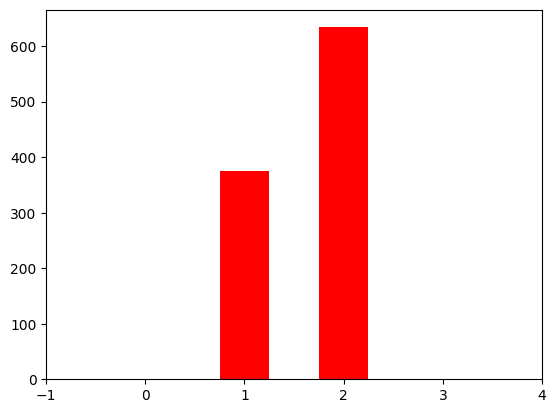

In [55]:

def get_activation_stats_by_digit(digit, model, dataloader):
    rulestat = {}
    with torch.no_grad():
        for _, (data, target) in enumerate(tqdm(dataloader)):
        
            data = data.to(device)
            fz,_ = model.forward(data)
            act_fz = fz.max(-1).indices.cpu().numpy()
            for ind, trg in zip(act_fz, target):
                if trg == digit:
                    rulestat[ind] = rulestat.get(ind, 0) + 1
    return rulestat


test_stat_by_digit = get_activation_stats_by_digit(9, model, test_loader)

plt.bar(list(test_stat_by_digit.keys()), test_stat_by_digit.values(), 0.5, color='r')
plt.xlim((-1, latent_dim + 1))

In [56]:
test_stat_by_digit

{1: 375, 2: 634}

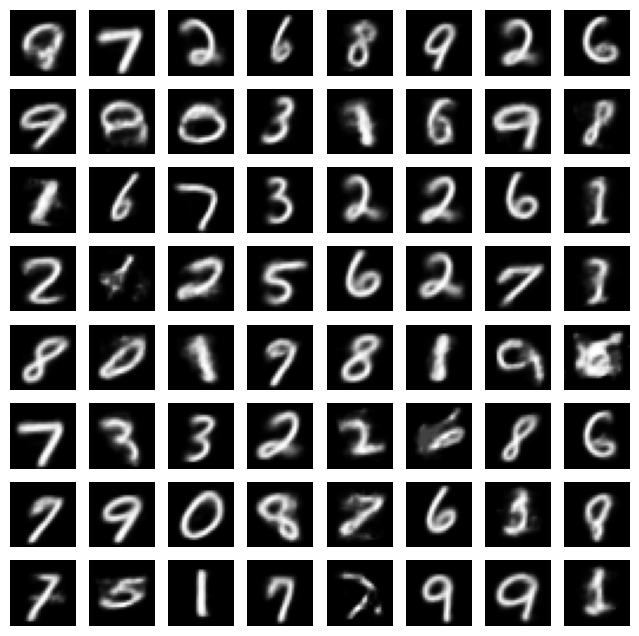

In [57]:
z = torch.randn(64, latent_dim).to(device)
samples = model.decoder_pass(z)

# Plot the generated images
fig, ax = plt.subplots(8, 8, figsize=(8, 8))
for i in range(8):
    for j in range(8):
        ax[i, j].imshow(samples[i*8+j].view(28, 28).cpu().detach().numpy(), cmap='gray')
        ax[i, j].axis('off')


In [58]:
# fz = torch.zeros(64, fuzzy_rules_count).to(device)
# for i in range(64):
#     fz[i][5] = 1.0/(i+1)

# samples = model.decoder.decode_from_fz(fz)

# # Plot the generated images
# fig, ax = plt.subplots(8, 8, figsize=(8, 8))
# for i in range(8):
#     for j in range(8):
#         ax[i, j].imshow(samples[i*8+j].view(28, 28).cpu().detach().numpy(), cmap='gray')
#         ax[i, j].axis('off')

# # plt.show()
# plt.savefig('cvae_mnist.webp')

In [59]:
ssim = piqa.SSIM(window_size = 9, n_channels=1, reduction='none').to(device)
def get_arate(inp):
    _, x_recon = model.forward(inp)
    #_, x_recon, fz_2 = model.forward(x_recon)
    
    return (1 - ssim(x_recon.clamp(0, 1), inp)).cpu().numpy() #(1 - ssim((x_recon + 1)/2, (inp + 1)/2)).cpu().numpy()#xent_continuous_ber((x_recon + 1)/2, (inp + 1)/2).cpu().numpy()# (1 - ssim((x_recon + 1)/2, (inp + 1)/2)).cpu().numpy() #ssim((inp + 1)/2, (recon_x+1)/2).cpu().numpy() #fz.sum(-1).cpu().numpy()#

MNIST HIST:   0%|          | 0/40 [00:00<?, ?it/s]

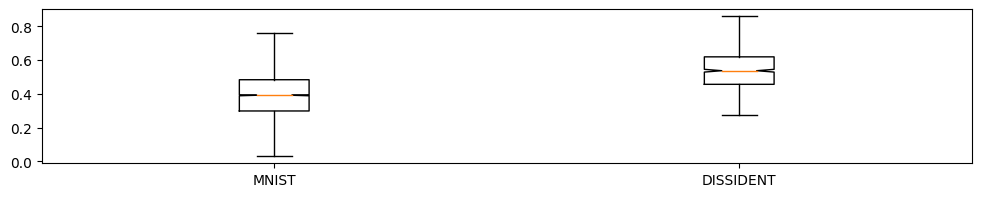

In [60]:
firings_mnist = {}
firings_mnist['MNIST'] = []
firings_mnist['DISSIDENT'] = []

with torch.no_grad():
    for data, target in tqdm(test_loader, desc='MNIST HIST'):
        data = data.view((-1,1,28,28)).to(device)
        rates = get_arate(data)
        for f, l in  zip(rates, target):
            if l != mnist_class_anomaly:
                firings_mnist['MNIST'].append(f)
            else:
                firings_mnist['DISSIDENT'].append(f)
        

labels, data = firings_mnist.keys(), firings_mnist.values()

fig = plt.figure(figsize =(12, 2))
plt.boxplot(data, notch=True, showfliers=False)
plt.xticks(range(1, len(labels) + 1), labels)
plt.show()

writer.add_figure('Anomaly Detection', fig)

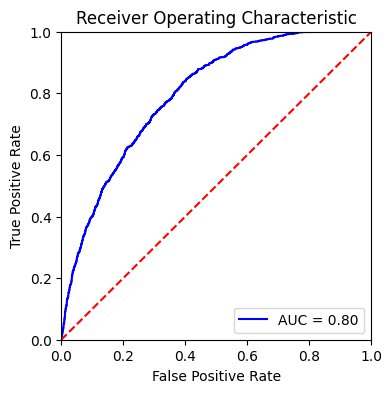

In [61]:
with torch.no_grad():
    firing_levels = []
    lab_true = []
    lab_pred = []

    for data, lab in tqdm(test_loader, desc='Test MNIST', disable=True):
        data = data.view((-1,1,28,28)).to(device)
        rates = get_arate(data)
        
        for f, l in  zip(rates, lab):
            firing_levels.append(f)
            lab_pred.append(f)        
            if l == mnist_class_anomaly:
                lab_true.append(1)
            else:
                lab_true.append(0)
                    
    fpr, tpr, threshold = metrics.roc_curve(lab_true, lab_pred)
    roc_auc = metrics.auc(fpr, tpr)
    
    fig = plt.figure(figsize =(4, 4))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    writer.add_figure('ROC', fig)

Encoding:   0%|          | 0/40 [00:00<?, ?it/s]

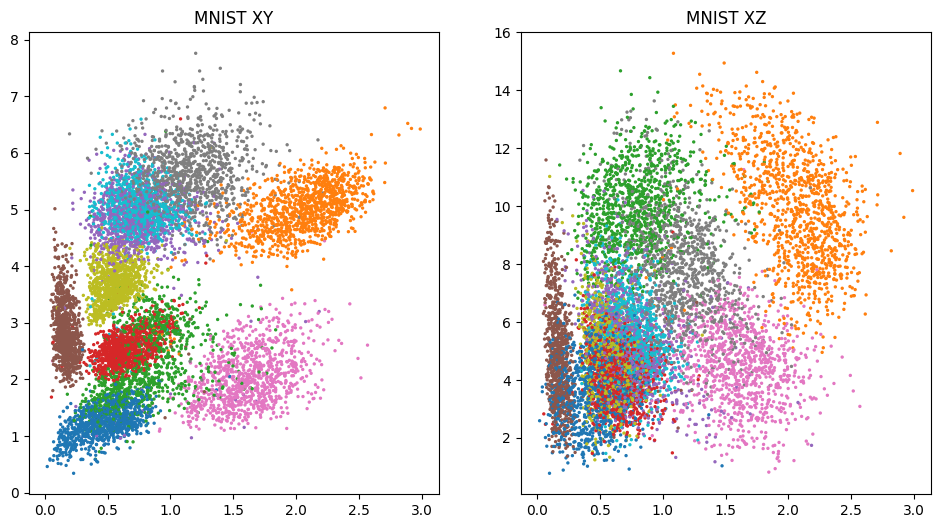

In [64]:
def show_plot():
    centroids = model.encoder.fuzzy.get_centroids().detach().cpu().numpy()
    embedings = []
    labels_expected = []
    with torch.no_grad():
        for data, target in tqdm(test_loader, desc='Encoding'):
            data = data.view((-1,1,28,28)).to(device)
            embeding,_ = model.forward(data)
            embedings.append(embeding.cpu().numpy())
            labels_expected.append(target.cpu().numpy())
    embedings = np.concatenate(embedings, axis=0)
    labels_expected = np.concatenate(labels_expected, axis=0)

    plt.figure(figsize=(18, 6))

    R, C = 1, 3

    plt.subplot(R, C, 1)
    plt.title("MNIST XY")
    plt.scatter(embedings[:, 0],      embedings[:,  1], c=labels_expected, cmap='tab10', s=2)
    #plt.scatter(centroids[:, 0],      centroids[:, 1], marker='1', c='black', s= 50)

    plt.subplot(R, C, 2)
    plt.title("MNIST XZ")
    plt.scatter(embedings[:, 0],      embedings[:,  2], c=labels_expected, cmap='tab10', s=2)
    #plt.scatter(centroids[:, 0],      centroids[:, 2], marker='1', c='black', s= 50)

    
show_plot()

In [65]:
def show_item_reconstructio(ind):
    for data, trg in iter(test_loader):
        data = data.to(device)
        _, x_rec = model.forward(data)
        #_, x_rec_2, fz_2 = model.forward(x_rec)

        plt.figure(figsize=(24, 6))

        R, C = 1, 6

        #plt.subplot(R, C, 1)
        #plt.imshow(fz[ind].detach().cpu().squeeze())
        #plt.bar(range(fuzzy_rules_count), fz[ind].detach().cpu().numpy(), color='g')
        #plt.bar(range(fuzzy_rules_count), fz_2[ind].detach().cpu().numpy(), color='r')
        plt.subplot(R, C, 1)
        plt.imshow(data[ind].cpu().squeeze())
        plt.subplot(R, C, 2)
        plt.imshow(x_rec[ind].detach().cpu().squeeze())
        #plt.subplot(R, C, 3)
        #plt.imshow(x_rec_2[ind].detach().cpu().squeeze())
        plt.subplot(R, C, 3)
        plt.imshow((x_rec[ind] - data[ind]).abs().detach().cpu().squeeze())
        #plt.subplot(R, C, 4)
        #plt.imshow(((data[ind]-x_rec[ind]).abs() - x_resd[ind]).abs().clamp(min=0.2).abs().detach().cpu().squeeze())
        break

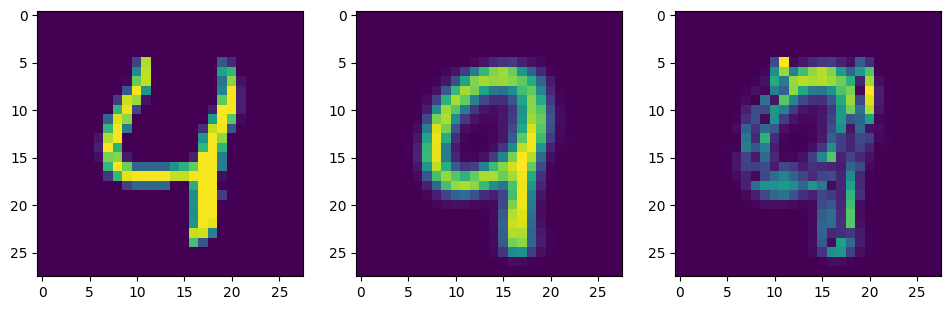

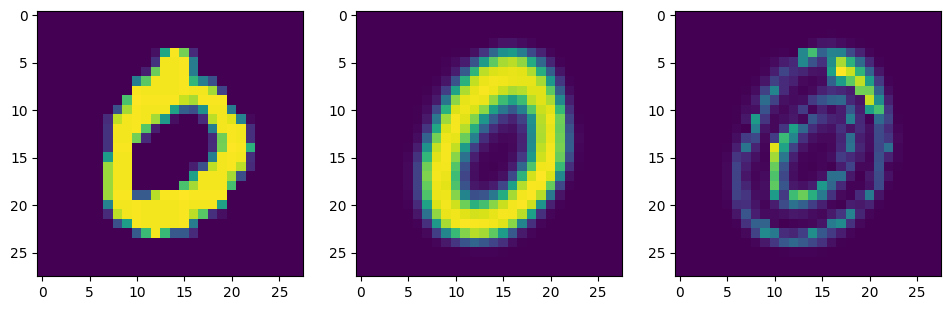

In [66]:
show_item_reconstructio(4)
show_item_reconstructio(3)